# Sentence Embedding

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/TC.csv',sep=',',encoding='gb18030',usecols=[0,2])
df.iloc[:3]

,輸入問題,Intent number
0,滙豐白金 Visa 卡想知年費幾多?,3053
1,請問白金visa年費收費係點?,3053
2,我想知我現時按揭計劃係 H+幾多% 同 P-幾多%,3082


In [ ]:
len(df)

14549

In [ ]:
shuffled = df.sample(frac=1)
splitdf = np.array_split(shuffled, 400)
# for re in splitdf:
#   print(len(re))
splitdf[3].iloc[:3]

,輸入問題,Intent number
714,想問下如果去日本11日 旅遊保費幾多錢,3081
12774,轉帳去恆生銀行上限是多少,3276
7367,"請問, 我要在網上我HSBC戶口轉錢去我的BOC戶口, 要收費嗎?",3017


In [ ]:
sentences = []
targets = []
for re in splitdf:
  sen = []
  tar = []
  for index, row in re.iterrows():
    sen.append(row['輸入問題'])
    tar.append(row['Intent number'])
  sentences.append(sen)
  targets.append(tar)
print(len(sentences),len(targets))
print(len(sentences[0]),len(targets[0]))

400 400
37 37


In [ ]:
pip install transformers

     |████████████████████████████████| 2.0MB 8.0MB/s 
     |████████████████████████████████| 3.2MB 36.8MB/s 
     |████████████████████████████████| 890kB 45.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=841887d6cb736e868fb090c7f6e766607977fb9e55bf199cc8b912367bc20d80
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertModel,BertConfig,BertTokenizer

In [ ]:
for i in range(len(sentences)):
  for j in range(len(sentences[i])):
    sentences[i][j] = '[CLS]'+sentences[i][j]+'[SEP]'
sentences[0][:2]

['[CLS]請問海外匯款可以在網上辦理嗎[SEP]',
 '[CLS]sorry, 多件事, 係第三個step  "保安編碼器螢幕將顯示保安編碼 " 輸入完密碼, 部機無反應, 是因為第一個step未完成所以無反應嗎??[SEP]']

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [ ]:
tokens, segments, input_masks = [], [], []
for sent in sentences:
  tok,seg,inp = [],[],[]
  for text in sent:
    tokenized_text = tokenizer.tokenize(text) #用tokenizer对句子分词
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)#索引列表
    tok.append(indexed_tokens)
    seg.append([0] * len(indexed_tokens))
    inp.append([1] * len(indexed_tokens))
  tokens.append(tok)
  segments.append(seg)
  input_masks.append(inp)
print(len(tokens),len(segments),len(input_masks))

400 400 400


In [ ]:
max_len = 0
for i in range(len(tokens)):
  for j in range(len(tokens[i])):
    # print(len(tokens[i][j]))
    max_len = max(max_len,len(tokens[i][j]))
print(max_len)

218


In [ ]:
for i in range(len(tokens)):
  for j in range(len(tokens[i])):
    padding = [0] * (max_len - len(tokens[i][j]))
    tokens[i][j] += padding
    segments[i][j] += padding
    input_masks[i][j] += padding

In [ ]:
for i in range(len(splitdf)):
  splitdf[i]['token'] = tokens[i]
  splitdf[i]['segment'] = segments[i]
  splitdf[i]['mask'] = input_masks[i]
tokens[3][:3]
splitdf[3].iloc[:3]

,輸入問題,Intent number,token,segment,mask
714,想問下如果去日本11日 旅遊保費幾多錢,3081,"[101, 2682, 1558, 678, 1963, 3362, 1343, 3189,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
12774,轉帳去恆生銀行上限是多少,3276,"[101, 6752, 2379, 1343, 2604, 4495, 7065, 6121...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
7367,"請問, 我要在網上我HSBC戶口轉錢去我的BOC戶口, 要收費嗎?",3017,"[101, 6313, 1558, 117, 2769, 6206, 1762, 5206,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
pip install torch

In [ ]:
import torch
import torch.nn as nn

In [ ]:
tokens_tensor, segments_tensors, input_masks_tensors = [],[],[]
for i in range(len(tokens)):
  tokens_tensor.append(torch.tensor(tokens[i]))
  segments_tensors.append(torch.tensor(segments[i]))
  input_masks_tensors.append(torch.tensor(input_masks[i]))

In [ ]:
len(tokens_tensor[0][0])

218

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow

In [ ]:
class BertTextNet(nn.Module):
    def __init__(self,code_length): #code_length为fc映射到的维度大小
        super(BertTextNet, self).__init__()
 
        modelConfig = BertConfig.from_pretrained('bert-base-chinese')
        self.textExtractor = BertModel.from_pretrained(
            'bert-base-chinese', config=modelConfig)
        embedding_dim = self.textExtractor.config.hidden_size
 
        self.fc = nn.Linear(embedding_dim, code_length)
        self.tanh = torch.nn.Tanh()
 
    def forward(self, tokens, segments, input_masks):
        output=self.textExtractor(tokens, token_type_ids=segments,
                                 		attention_mask=input_masks)
        text_embeddings = output[0][:, 0, :]  
        #output[0](batch size, sequence length, model hidden dimension)
 
        features = self.fc(text_embeddings)
        features=self.tanh(features)
        return features

textNet = BertTextNet(code_length=32)

In [ ]:
'result_{}.csv'.format(5)

'result_5.csv'

In [ ]:
import gc

In [ ]:
text_hashCodes = textNet.forward(tokens_tensor[0],segments_tensors[0],input_masks_tensors[0])
splitdf[0]['vector'] = list(text_hashCodes.detach().numpy())
splitdf[0].to_csv('result_{}.csv'.format(0),encoding='gb18030')
splitdf[0].iloc[:3]

,輸入問題,Intent number,token,segment,mask,vector
13003,"請問我在轉帳果度新增受款人, SET了新受款人及限額, 幾時才生效?",3260,"[101, 6313, 1558, 2769, 1762, 6752, 2379, 3362...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.23791565, 0.16812079, -0.07795819, 0.177374..."
6932,ebanking的提示答案即是什麼？,1041,"[101, 11129, 9705, 8221, 4638, 2990, 4850, 503...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.013353862, 0.6092425, 0.36454335, -0.116481..."
1390,hi...請問TT去法國手續費係幾多？,3033,"[101, 8913, 119, 119, 119, 6313, 1558, 100, 13...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.056076854, 0.3664655, 0.42902738, 0.2243168..."


In [ ]:
for i in range(len(splitdf)):
  text_hashCodes = textNet.forward(tokens_tensor[i],segments_tensors[i],input_masks_tensors[i])
  splitdf[i]['vector'] = list(text_hashCodes.detach().numpy())
  # splitdf[i].to_csv('result_{}.csv'.format(i),encoding='gb18030')
  print(i)
  del text_hashCodes
  # del text_hashCodes_1
  gc.collect()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# text_hashCodes_1 = textNet.forward(tokens_tensor[:101],segments_tensors[:101],input_masks_tensors[:101])
# resultDF_1['vector'] = pd.Series(list(text_hashCodes_1.detach().numpy()))
# resultDF_1.to_csv('result1.csv',encoding='gb18030')
# resultDF_1.iloc[:3]

,sentence,target,token,segment,mask,vector
0,滙豐白金 Visa 卡想知年費幾多?,3053,"[101, 4002, 6493, 4635, 7032, 100, 1305, 2682,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.5561687, 0.35396686, 0.28764316, -0.556288..."
1,我想知我現時按揭計劃係 H+幾多% 同 P-幾多%,3082,"[101, 2769, 2682, 4761, 2769, 4412, 3229, 2902...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.6591209, 0.5228202, 0.10336599, -0.0987041..."
2,換另外一張八達通要收20蚊手續費？,3070,"[101, 2994, 1369, 1912, 671, 2484, 1061, 6888,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.23733288, 0.19026394, 0.6233021, 0.0958565..."


In [ ]:
# del resultDF_2
# del text_hashCodes_2
# import gc
# gc.collect()

281

In [ ]:
df_vector = pd.concat(splitdf)
print(len(df_vector))

14549


In [ ]:
df_vector.iloc[:3]

,輸入問題,Intent number,token,segment,mask,vector
11902,請問海外匯款可以在網上辦理嗎,3206,"[101, 6313, 1558, 3862, 1912, 1274, 3621, 1377...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.09726616, 0.16526133, -0.13473101, -0.12328..."
5462,"sorry, 多件事, 係第三個step ""保安編碼器螢幕將顯示保安編碼 "" 輸入完密碼,...",1011,"[101, 12758, 117, 1914, 816, 752, 117, 913, 50...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.1823902, -0.21298595, -0.108888336, -0.238..."
11334,在轉帳貨幣中沒有台幣的選項,3256,"[101, 1762, 6752, 2379, 6515, 2395, 704, 3760,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.024255099, -0.264613, -0.16737893, 0.18928..."


In [ ]:
# df_vector.to_csv('result_vector.csv',encoding='gb18030')
df_vector.to_json('result_vector.json')

In [ ]:
df_vector['vector'].values

array([array([ 0.09726616,  0.16526133, -0.13473101, -0.12328652, -0.2687281 ,
       -0.30481404,  0.49342903, -0.4194833 , -0.5338449 , -0.22984709,
        0.12782072,  0.68198615,  0.01592636,  0.24974252, -0.48304224,
        0.15461259, -0.5501876 ,  0.6807754 , -0.63090867,  0.41891947,
       -0.66070044, -0.53768224, -0.10107061, -0.6078259 , -0.17240605,
        0.3860476 ,  0.5997795 ,  0.39473888, -0.7253354 , -0.34958205,
        0.47046778,  0.12872507], dtype=float32),
       array([-0.1823902 , -0.21298595, -0.10888834, -0.23864546,  0.01052955,
       -0.10265493,  0.270015  , -0.09676845,  0.0291921 , -0.24539311,
        0.02066872,  0.3374136 , -0.31315705,  0.2528925 , -0.40834558,
       -0.09763176,  0.12685244,  0.65605223, -0.7111108 ,  0.40720433,
       -0.8305327 , -0.7304861 ,  0.35168627, -0.03249304, -0.44132367,
        0.4306069 ,  0.5437113 ,  0.28961626, -0.5114442 ,  0.3182793 ,
        0.6748008 , -0.248735  ], dtype=float32),
       array([-0.02425

# Classification

参考
https://blog.csdn.net/Xiao_CangTian/article/details/108289902
https://www.cnblogs.com/douzujun/p/13580157.html#_label1_4
https://www.cnblogs.com/wyhluckdog/p/11842285.html

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 5.6MB/s 
     |████████████████████████████████| 3.3MB 19.8MB/s 
     |████████████████████████████████| 870kB 38.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=42ccdf71daa2f529cb04b787835cd05d5bc04e02fe780752d8619ceac58fca8c
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import matplotlib.pylab as plt 
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
 
SEED = 123
BATCH_SIZE = 16
learning_rate = 2e-5
weight_decay = 1e-2
epsilon = 1e-8
 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
df_data = pd.read_json('/content/result_vector.json')
df_data.iloc[:3]

,輸入問題,Intent number,token,segment,mask,vector
11902,請問海外匯款可以在網上辦理嗎,3206,"[101, 6313, 1558, 3862, 1912, 1274, 3621, 1377...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.09726616, 0.1652613282, -0.1347310096, -0.1..."
5462,"sorry, 多件事, 係第三個step ""保安編碼器螢幕將顯示保安編碼 "" 輸入完密碼,...",1011,"[101, 12758, 117, 1914, 816, 752, 117, 913, 50...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.1823901981, -0.2129859477, -0.1088883355, ..."
11334,在轉帳貨幣中沒有台幣的選項,3256,"[101, 1762, 6752, 2379, 6515, 2395, 704, 3760,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.0242550988, -0.2646130025, -0.1673789322, ..."


In [ ]:
input_tokens = df_data['token'].values.tolist()
atten_masks = df_data['mask'].values.tolist()
total_targets = df_data['Intent number'].values

In [ ]:
for i in range(len(input_tokens)):
    input_tokens[i] = list(input_tokens[i])
print(type(input_tokens))
for i in range(len(atten_masks)):
    atten_masks[i] = list(atten_masks[i])
print(type(atten_masks))

<class 'list'>
<class 'list'>


In [ ]:
input_tokens = torch.tensor(input_tokens)
total_targets = torch.tensor(total_targets)
atten_masks = torch.tensor(atten_masks)

In [ ]:
from sklearn.model_selection import train_test_split
 
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_tokens, total_targets, 
                                                                        random_state=666, test_size=0.2)
train_masks, test_masks, _, _ = train_test_split(atten_masks, input_tokens, 
                                                 random_state=666, test_size=0.2)
print(train_inputs.shape, test_inputs.shape)      # torch.Size([8000, 128]) torch.Size([2000, 128])
print(train_masks.shape)                          # torch.Size([8000, 128])和train_inputs形状一样
 
print(train_inputs[0])
print(train_masks[0])

torch.Size([11639, 218]) torch.Size([2910, 218])
torch.Size([11639, 218])
tensor([ 101,  872, 1962, 8024, 2769, 2682, 7309,  671,  678, 8024, 2769, 6206,
         794,  704, 1744, 3726, 3621, 5635, 2769, 4638, 7676, 3949, 3726,  705,
        6572, 2787, 8024, 3726, 3621, 4638,  100, 3221,  784,  720,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
 
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
for i, (train, mask, label) in enumerate(train_dataloader): 
    # torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 1])
    print(train.shape, mask.shape, label.shape)
    break

print('len(train_dataloader) = ', len(train_dataloader))    # 500

torch.Size([16, 218]) torch.Size([16, 218]) torch.Size([16])
len(train_dataloader) =  728


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels = 333) # num_labels表示2个分类,好评和差评
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(), lr = 0.05)

In [ ]:
epochs = 2
# training steps 的数量: [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs
 
# 设计 learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
import time
import datetime

def binary_acc(preds, labels):
    correct = torch.eq(torch.max(preds, dim=1)[1], labels.flatten()).float() # eq里面的两个参数的shape=torch.Size([16])
    acc = correct.sum().item() / len(correct)
    return acc
 
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds = elapsed_rounded)) # 返回 hh:mm:ss 形式的时间

In [ ]:
def train(model, optimizer):
    t0 = time.time()
    avg_loss, avg_acc = [],[]

    model.train()
    for step, batch in enumerate(train_dataloader):

        # 每隔40个batch 输出一下所用时间.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids, b_input_mask, b_labels = batch[0].long().to(device), batch[1].long().to(device), batch[2].long().to(device)

        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss, logits = output[0], output[1]      # loss: 损失, logits: predict

        avg_loss.append(loss.item())

        acc = binary_acc(logits, b_labels)       # (predict, label)
        avg_acc.append(acc)

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0) # 大于1的梯度将其设为1.0, 以防梯度爆炸
        optimizer.step()                         # 更新模型参数
        scheduler.step()                         # 更新learning rate

    avg_acc = np.array(avg_acc).mean()
    avg_loss = np.array(avg_loss).mean()
    return avg_loss, avg_acc

In [ ]:
def evaluate(model):
    avg_acc = []
    model.eval()         # 表示进入测试模式

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_input_mask, b_labels = batch[0].long().to(device), batch[1].long().to(device), batch[2].long().to(device)

            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

            acc = binary_acc(output[0], b_labels)
            avg_acc.append(acc)

    avg_acc = np.array(avg_acc).mean()
    return avg_acc

In [ ]:
for epoch in range(epochs):

    train_loss, train_acc = train(model, optimizer)
    print('epoch={},训练准确率={}，损失={}'.format(epoch, train_acc, train_loss))
    
    test_acc = evaluate(model)
    print("epoch={},测试准确率={}".format(epoch, test_acc))

IndexError: ignored

In [ ]:
import gc
gc.collect()

366

# Clustering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_json('/content/result_vector.json')
df.iloc[:3]

,輸入問題,Intent number,token,segment,mask,vector
11902,請問海外匯款可以在網上辦理嗎,3206,"[101, 6313, 1558, 3862, 1912, 1274, 3621, 1377...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.09726616, 0.1652613282, -0.1347310096, -0.1..."
5462,"sorry, 多件事, 係第三個step ""保安編碼器螢幕將顯示保安編碼 "" 輸入完密碼,...",1011,"[101, 12758, 117, 1914, 816, 752, 117, 913, 50...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.1823901981, -0.2129859477, -0.1088883355, ..."
11334,在轉帳貨幣中沒有台幣的選項,3256,"[101, 1762, 6752, 2379, 6515, 2395, 704, 3760,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.0242550988, -0.2646130025, -0.1673789322, ..."


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [ ]:
feature = df['vector'].values.tolist()
# km = KMeans(n_clusters=9).fit(feature)
# df['cluster'] = km.labels_
# df.iloc[:3]

10
20
30
40
50
60
70
80
90


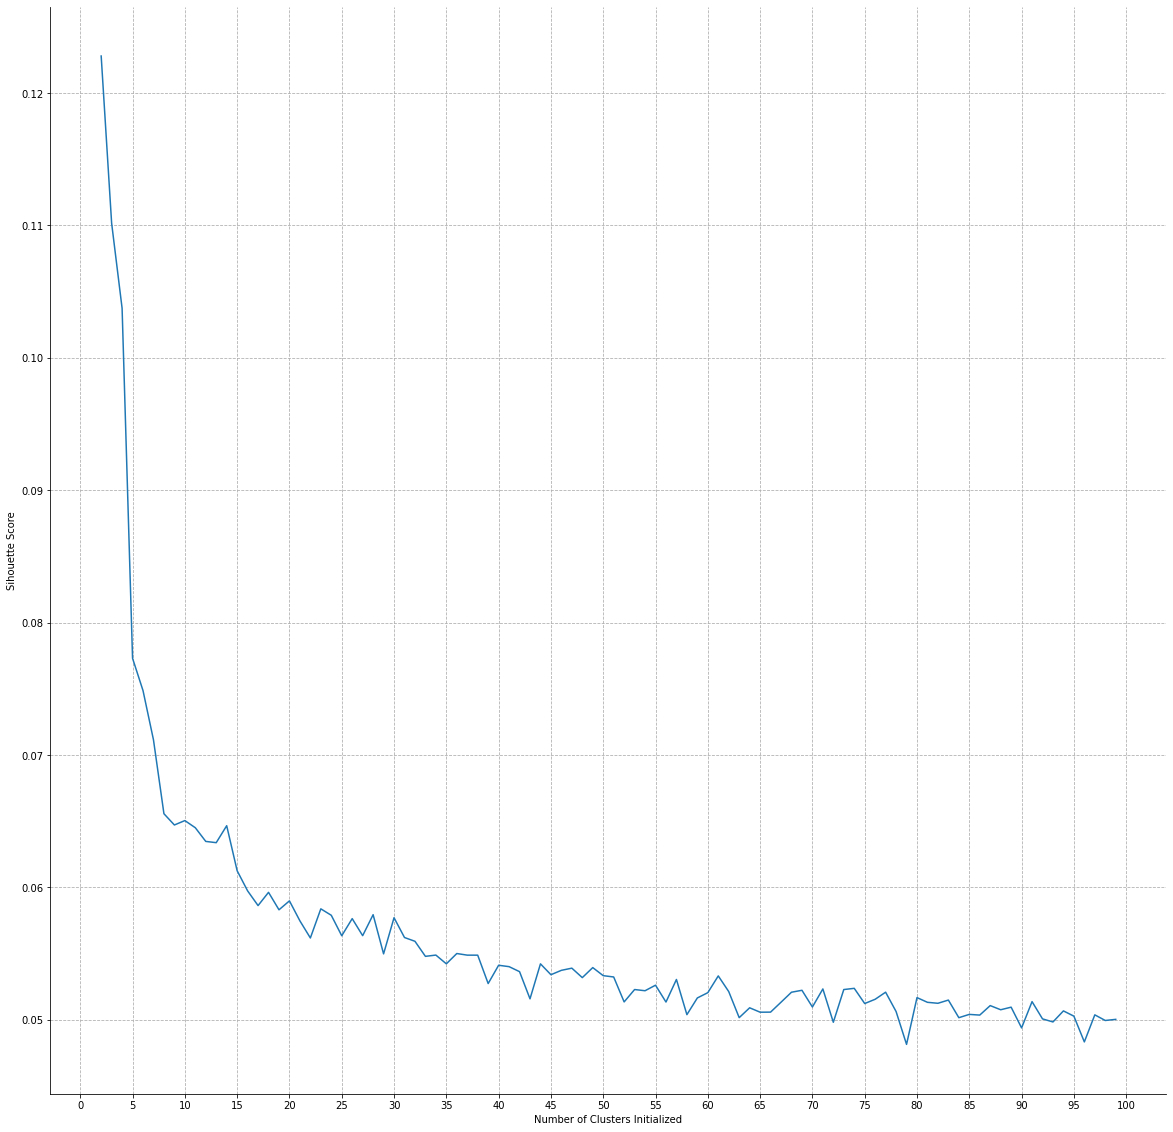

In [ ]:
# 轮廓系数Silhouette Coefficient
scores = []
for k in range(2,100):
  labels = KMeans(n_clusters=k).fit(feature).labels_
  score = metrics.silhouette_score(feature, labels)
  if k%10 == 0: print(k)
  scores.append(score)

plt.figure(figsize=(20,20))
plt.plot(list(range(2,100)),scores)
plt.xticks(range(0,101,5)) 
plt.grid(linestyle='--')
plt.xlabel("Number of Clusters Initialized")
plt.ylabel("Sihouette Score")
sns.despine()

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(list(range(2,100)),list(range(2,100)))
plt.show()